In [73]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [74]:
leaf_pixel_x = 25
leaf_pixel_y = 25
start_band = 0
end_band = 224
band_delta = end_band - start_band
band_range = bands[start_band:end_band]

In [75]:
import numpy as np
import matplotlib.pyplot as plt

rois_old = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("results/rois_old{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_old = np.append(rois_old, current_rois, axis=0)

rois_old = np.delete(rois_old, np.s_[0:6], axis=0)
rois_old.shape

(18, 50, 50, 224)

In [76]:
rois_young = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("results/rois_young{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_young = np.append(rois_young, current_rois, axis=0)

rois_young = np.delete(rois_young, np.s_[0:6], axis=0)
rois_young.shape

(18, 50, 50, 224)

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(36, 224)


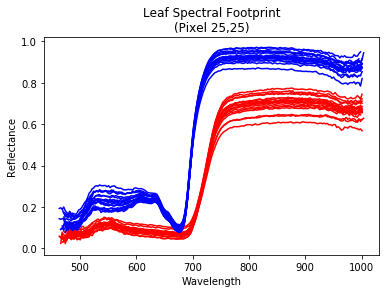

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)

leaf_pixels = np.empty((1, band_delta))

for i in range(rois_old.shape[0]):
    roi = rois_old[i]
    intensity = []
    
    for b in range(roi.shape[2]):
        intensity.append(np.mean(roi[:, :, b]))
        
    leaf_pixel = intensity
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed, 'r')
    leaf_pixels = np.append(leaf_pixels, [leaf_pixel_squeezed], axis=0)
    

for i in range (rois_young.shape[0]):
    roi = rois_young[i]
    intensity = []
    
    for b in range(roi.shape[2]):
        intensity.append(np.mean(roi[:, :, b]))
        
    leaf_pixel = intensity
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed ,'b')
    leaf_pixels = np.append(leaf_pixels, [leaf_pixel_squeezed], axis=0)
    
leaf_pixels = np.delete(leaf_pixels, (0), axis=0)  
print(leaf_pixels.shape)

plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show([-100, 100])

In [78]:
X = leaf_pixels
y = np.append(np.ones((18, 1), dtype=int), np.zeros((18, 1), dtype=int), axis=0)
X.shape, y.shape

((36, 224), (36, 1))

In [79]:
from sklearn.model_selection import train_test_split

# train size 5/6 or ~83.3%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36, 224), (36, 1), (30, 224), (6, 224), (30, 1), (6, 1))

In [80]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(112, input_dim=band_delta, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(112, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=30)

Train on 30 samples, validate on 6 samples
Epoch 1/30
30/30 [==============================] - 1s 39ms/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 0s 579us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 3/30
30/30 [==============================] - 0s 533us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 4/30
30/30 [==============================] - 0s 400us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 5/30
30/30 [==============================] - 0s 400us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 6/30
30/30 [==============================] - 0s 267us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00
Epoch 7/30
30/30 [==============================] - 0s 267us/step - loss: nan - acc: 0.0000e+00 - val_loss: 5.3141 - val_acc: 0.0000e+00

Test loss: 5.314128398895264
Test accuracy: 0.0


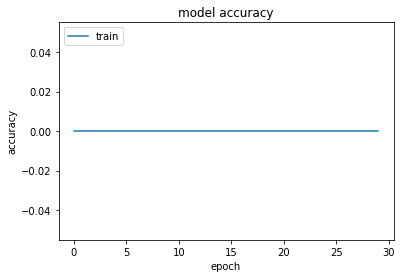

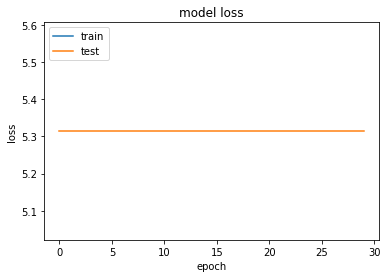

In [81]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()